## Waveform Frequency Prediction w/ RNN - Failed

Tried to make RNN model predict frequency of waveforms, unfortunately it attempt didn't make it, just leaving notes.

In [3]:
from dlcliche.notebook import *
from dlcliche.utils import *

import torch
import torch.nn as nn


def gen_sine(duration, freq, fs=44100):
    """
    Thanks to https://stackoverflow.com/a/27978895/6528729
    Args:
        fs: 44100       # sampling rate, Hz, must be integer
        duration: 1.0   # in seconds, may be float
        freq: 440.0        # sine frequency, Hz, may be float
    """
    # generate samples, note conversion to float32 array
    samples = (np.sin(2*np.pi*np.arange(fs*duration)*freq/fs)).astype(np.float32)
    return samples


def jupyter_play_audio(samples, fs=44100):
    display(IPython.display.Audio(data=samples, rate=fs))


s = gen_sine(1.0, 200)
jupyter_play_audio(s)

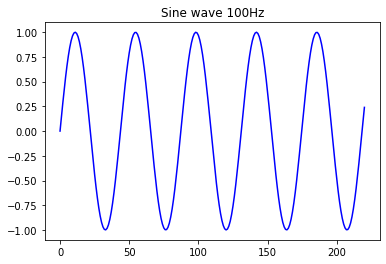

RNNFreq(
  (rnn): LSTM(1, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
0 0.25937992
1 0.26631272
2 0.21257246
3 0.1582387
4 0.22793739
5 0.16021113
6 0.1389235
7 0.13978824
8 0.1310457
9 0.1282321
10 0.098468766
11 0.09933906
12 0.07988536
13 0.11264625
14 0.09588471
15 0.11375651
16 0.09084787
17 0.10091568
18 0.065396465
19 0.111111246
20 0.05864582
21 0.07391323
22 0.076693594
23 0.08096688
24 0.10095373
25 0.12441622
26 0.08527648
27 0.09518844
28 0.0638455
29 0.13226116
30 0.07217992
31 0.09130131
32 0.09087391
33 0.10326166
34 0.08344251
35 0.08708169
36 0.051670346
37 0.07743617
38 0.0824856
39 0.10224503
40 0.110515706
41 0.09869156
42 0.10286685
43 0.060781516
44 0.07446001
45 0.06581358
46 0.09038977
47 0.08550869
48 0.088528715
49 0.0914634
50 0.09547728
51 0.078555055
52 0.07502471
53 0.078432225
54 0.10539486
55 0.10583996
56 0.1188989
57 0.09766576
58 0.08284935
59 0.089259975
60 0.07607579
61 0.06332428
62 0.0755763
63 0.075323515


539 0.07114354
540 0.09241812
541 0.06986042
542 0.08870762
543 0.06385646
544 0.08418567
545 0.082525276
546 0.07155325
547 0.0980756
548 0.11105765
549 0.114219315
550 0.076768436
551 0.09068059
552 0.083567515
553 0.06285783
554 0.077712595
555 0.0727189
556 0.099285066
557 0.086763754
558 0.09716269
559 0.10686785
560 0.067983106
561 0.09638852
562 0.089055605
563 0.08603531
564 0.08443834
565 0.07065546
566 0.084102355
567 0.10562699
568 0.082226284
569 0.08640711
570 0.073359236
571 0.074490085
572 0.078241214
573 0.094490826
574 0.07159389
575 0.08955544
576 0.059931736
577 0.09353453
578 0.1154311
579 0.074736
580 0.08235233
581 0.07298732
582 0.07840925
583 0.0749242
584 0.09209835
585 0.079375766
586 0.06374404
587 0.08474396
588 0.0869723
589 0.0849641
590 0.08672181
591 0.08808399
592 0.08415096
593 0.08698578
594 0.076750115
595 0.09764756
596 0.085189246
597 0.090498164
598 0.07895539
599 0.07842877
600 0.10513346
601 0.10095398
602 0.08521252
603 0.06371164
604 0.0727739

In [25]:
"""
https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/403_RNN_regressor.py
"""
from dlcliche.notebook import *

"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
numpy
"""
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.001           # learning rate
DURATION = 0.005
F_MIN, F_MAX = 1000, 1100
EPOCHS = 1000
BS = 32

def FREQ(normed):
    return ((F_MAX - F_MIN) * normed) + F_MIN

# show data
x_np = gen_sine(DURATION, FREQ(0.1))
plt.plot(x_np, 'b-', label='input (sin)')
plt.title('Sine wave 100Hz')
plt.show()


class RNNFreq(nn.Module):
    def __init__(self):
        super().__init__()

        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(128, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNNFreq()
print(rnn)

optimizer = torch.optim.AdamW(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()
losses = []

h_state = None      # for initial hidden state

for step in range(EPOCHS):
    # use sin predicts cos
    y_np, x_np = [], []
    for _ in range(BS):
        hz = np.random.random() # Hz
        y_np.append(hz)
        x_np.append(gen_sine(DURATION, FREQ(hz)))
    y_np, x_np = np.array(y_np, dtype=np.float32), np.array(x_np, dtype=np.float32)

    x = torch.from_numpy(x_np[..., np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np)

    prediction = rnn(x, None)   # rnn output

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    loss = loss.detach().numpy()
    losses.append(loss)
    #pred = prediction.data.numpy().flatten()[0]
    print(step, loss)

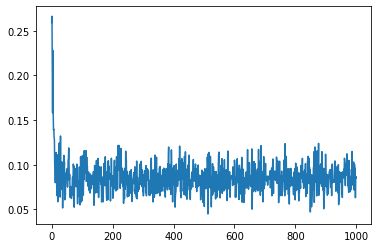

In [26]:
# LSTM 128,1, BS32
plt.plot(losses)

Text(0.5, 1.0, "Unfortunately it doesn't learn to predict Hz from waveform efficiently")

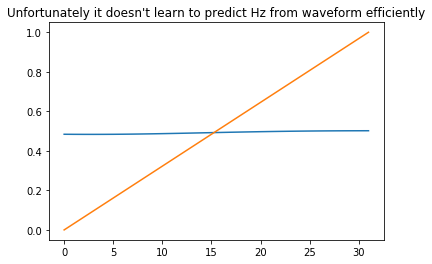

In [29]:
# visual evaluation
rnn.eval()

y_np, x_np = [], []
for hz in np.linspace(0., 1., num=BS):
    y_np.append(hz)
    x_np.append(gen_sine(DURATION, FREQ(hz)))
y_np, x_np = np.array(y_np, dtype=np.float32), np.array(x_np, dtype=np.float32)

x = torch.from_numpy(x_np[..., np.newaxis])    # shape (batch, time_step, input_size)
y = torch.from_numpy(y_np)

prediction = rnn(x, None)   # rnn output
pred = prediction.data.numpy().flatten()
plt.plot(pred)
plt.plot(y_np)
plt.title("Unfortunately it doesn't learn to predict Hz from waveform efficiently")

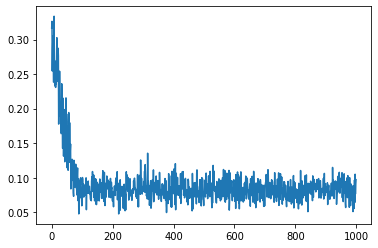

In [95]:
# GRU 128,1, BS32
plt.plot(losses)

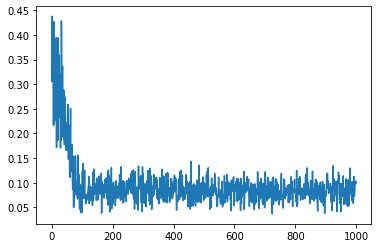

In [87]:
# GRU 128,1, BS16
plt.plot(losses)

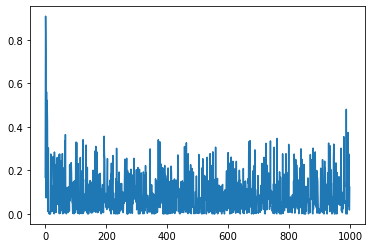

In [80]:
# GRU 256,3
plt.plot(losses)

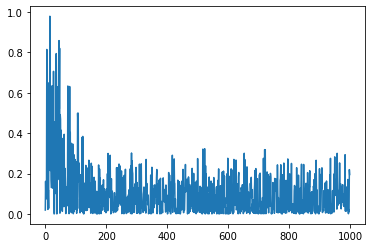

In [78]:
# GRU 128,1
plt.plot(losses)

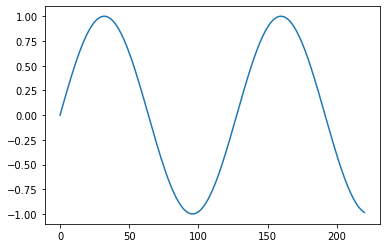

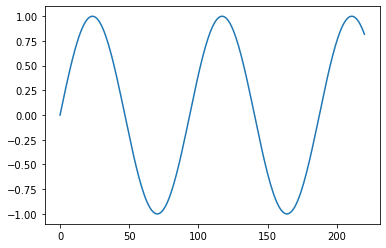

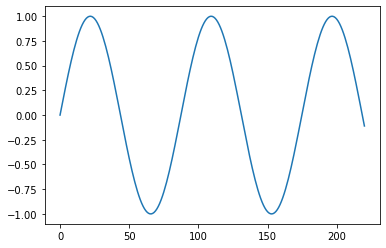

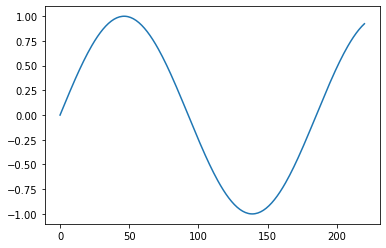

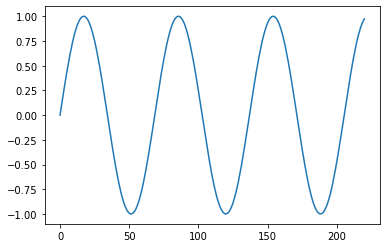

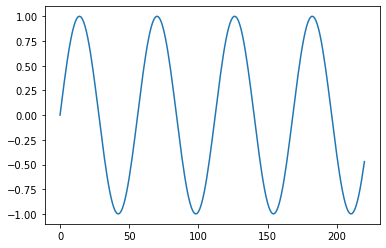

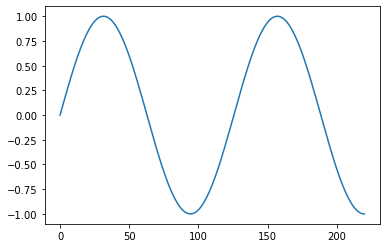

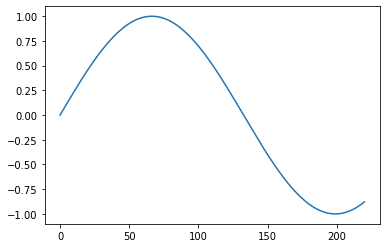

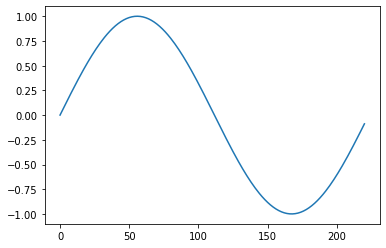

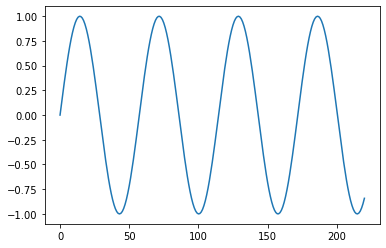

In [6]:
for i in range(10):
    y_np = np.random.random() # Hz
    x_np = gen_sine(DURATION, FREQ(y_np))
    plt.plot(x_np)
    plt.show()